In [5]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [6]:
# plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

def find_assist_periapsis_bounds(dep_num,sling_bod_orb,inc_orb_vel,date):
    sling_body=planet_order[dep_num]
    target_body = planet_order[dep_num+1]

    #relative velocity & speed to body we are slingshotting around
    rel_vel = inc_orb_vel-sling_bod_orb.rv()[1]
    rel_sped = np.linalg.norm(rel_vel)
    
    r_ps = sling_body.R+np.geomspace(r_p_min,r_p_max,num=int(assist_transit_resolution/2))*u.km
    
    rot_angs=2*np.arcsin(1/((r_ps*rel_sped*rel_sped/sling_body.k)+1*u.one))
    #Now check if these (in plane) rotations lead to an orbit that reaches the target body
    target_body_debug_orbit = Orbit.from_ephem(Sun,ephem_order[dep_num+1],date)
    
    axis = np.array([0,0,1.0])   #rotate in ecliptic plane intitially
    min_dv=1000000*u.km/u.s
    target_arrival_date=None

    for sign in [-1,1]:
        for i in range(len(rot_angs)):
            rot = scipyRot.from_rotvec(axis*rot_angs[i])
            rel_vel_out= rot.apply(rel_vel.value) * u.km/u.s
            test_orb = Orbit.from_vectors(Sun,sling_bod_orb.r,rel_vel_out+sling_bod_orb.rv()[1],date)
            #check if apogee of new orbit reaches target, or is hyperbolic
            #Note, does not work for gravity assists to bodies in lower orbits,
            #Thus will need changes for Jovian grand tour
            if (test_orb.r_a.value>target_body_debug_orbit.r_a.value and test_orb.ecc <1 or test_orb.ecc>1):
                # print(f"Success at closest approach of {r_ps[i].to(u.km):.2f} to {sling_body} on {date}")
                #find time to reach
                time_to_next=0
                reached_next_bod=False
                test_orb_prop=test_orb.propagate(0*u.day)
                while not reached_next_bod:
                    test_orb_prop=test_orb_prop.propagate(5*u.day)
                    time_to_next += 5*u.day
                    if np.linalg.norm(test_orb_prop.rv()[0]).value > target_body_debug_orbit.a.value:
                        reached_next_bod=True
                rough_arrival_date = date+time_to_next
                # print(f"Arrival at {target_body} at roughly {rough_arrival_date}")
                target_arrival_orb = Orbit.from_ephem(Sun,ephem_order[dep_num+1],rough_arrival_date)   
                #Now evaluate lambert to target body
                man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
                lambert_test_orb=sling_bod_orb.apply_maneuver(man_lambert,intermediate=True)[0]
                # print(lambert_test_orb.r)
                # print(sling_bod_orb.r)
                # print(test_orb.r)
                speed_dif=abs(np.linalg.norm((lambert_test_orb.rv()[1]-sling_bod_orb.rv()[1])) - np.linalg.norm((test_orb.rv()[1]-sling_bod_orb.rv()[1])))
                if speed_dif < min_dv:
                    # print(min_dv)
                    min_dv=speed_dif
                    target_arrival_date=deepcopy(rough_arrival_date)
                # print(f"Minimum DV {speed_dif.to(u.km/u.s):.2f}")

            # else:
            #     print("failure")
    # print(f"It takes {min_dv} to reach {target_body.name} arriving at {target_arrival_date}")
    # print(f"Trying to arrive at {target_body.name} on {target_arrival_date}")
    target_arrival_orb = Orbit.from_ephem(Sun, ephem_order[dep_num + 1], target_arrival_date)
    man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
    outgoing_orb = sling_bod_orb.apply_maneuver(man_lambert, intermediate=True)[0]
    
    # plotter.plot(target_arrival_orb, label=f"{target_body.name} Orbit")
    # plotter.plot(outgoing_orb, label=f"Post-Assist Orbit")
    # plotter.plot(sling_bod_orb, label=f"{sling_body.name} Orbit")
    return min_dv, target_arrival_date, outgoing_orb
    
                
                
    
    


In [7]:
#search for viable Earth-Jupiter transit
resolution=7#days
min_tof=400#days
max_tof=800#days

assist_transit_resolution = 80 #number of periapsis values to scan over for viablish slingshots

#max and min flyby distances
r_p_min=50000
r_p_max=950000

first_date=time.Time("2035-09-05 00:01", scale="utc").tdb
arb_extra_date = time.Time("2041-11-05 00:01", scale="utc").tdb
buffer = 100*u.day

final_date=time.Time("2045-10-01 00:01", scale="utc").tdb



# ephem_earth=Ephem.from_horizons("399", time_range(first_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
# ephem_jupiter=Ephem.from_horizons("599", time_range(first_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
# ephem_saturn=Ephem.from_horizons("699", time_range(first_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
# ephem_uranus=Ephem.from_horizons("799", time_range(first_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)
# ephem_neptune=Ephem.from_horizons("899", time_range(first_date,end=final_date),plane=Planes.EARTH_ECLIPTIC)


ephem_earth = Ephem.from_body(Earth, time_range(first_date,end=arb_extra_date+max_tof+buffer,periods=300),plane=Planes.EARTH_ECLIPTIC)
ephem_jupiter = Ephem.from_body(Jupiter, time_range(first_date,end=final_date,periods=1000),plane=Planes.EARTH_ECLIPTIC)
ephem_saturn = Ephem.from_body(Saturn, time_range(first_date,end=final_date,periods=1000),plane=Planes.EARTH_ECLIPTIC)
ephem_uranus = Ephem.from_body(Uranus, time_range(first_date,end=final_date,periods=1000),plane=Planes.EARTH_ECLIPTIC)
ephem_neptune = Ephem.from_body(Neptune, time_range(first_date,end=final_date,periods=1000),plane=Planes.EARTH_ECLIPTIC)
planet_order=[Earth, Jupiter, Saturn]#, Uranus, Neptune]
ephem_order = [ephem_earth, ephem_jupiter, ephem_saturn]#, ephem_uranus, ephem_neptune]

In [11]:
# plotter = StaticOrbitPlotter()

#Delete below when done testing

found_grand_tour=False
#Delete above

total_scans=0
total_viable_ejects=0
assist_1_count=0
assist_2_count=0


dv_maneuvers_total=0
arrive_bod_1=None
orb_after_1=None

tof_range=np.arange(min_tof,max_tof,resolution)*u.day
launch_dates = time_range(start=first_date, end=arb_extra_date,periods=100)


# launch_date=time.Time("1977-08-30 18:43:24.514", scale="utc").tdb
# tof=688*u.day

for launch_date in launch_dates:
    for tof in tof_range:
        arrive_date=launch_date+tof
        


        earth_orb = Orbit.from_ephem(Sun, ephem_earth, launch_date)
        jupiter_orb = Orbit.from_ephem(Sun, ephem_jupiter, arrive_date)
        man_lambert = Maneuver.lambert(earth_orb, jupiter_orb, M=0)
        # print(man_lambert[0])
        ej_dv= np.linalg.norm(man_lambert[0][1].value)
        #viable transit found
        total_scans+=1
        if ej_dv < 11000:#roughly what Titan IV could do
            print(f"Found Earth-Jupiter transit with DV {ej_dv*u.km/u.s:.2f} on launch {launch_date} arriving {arrive_date} with transit time {tof.to(u.day):.0f}")
            trans_orb, final_orb = earth_orb.apply_maneuver(man_lambert, intermediate=True)
            launch_orbit=deepcopy(trans_orb)
            voyager_orbits.append(launch_orbit)
            trans_orb=trans_orb.propagate(tof)
            test_orb=jupiter_orb
            test_v=trans_orb.rv()[1]
            test_launch=launch_date
            test_epoch=arrive_date
            total_viable_ejects+=1
            
            
            
            dv_maneuvers_total,arrive_bod_2_date, orb_after_1=find_assist_periapsis_bounds(1,jupiter_orb,trans_orb.rv()[1],arrive_date)
            assist_1=deepcopy(orb_after_1)
            voyager_orbits.append(assist_1)
            flybys_dates.append(arrive_date)
            planet_orbits.append(earth_orb)
            planet_orbits.append(jupiter_orb)
            
            # print(dv_maneuvers_total)
            if(dv_maneuvers_total<100*u.m/u.s):
                print(f"Viable assist at {arrive_date} with {planet_order[1]} to {planet_order[2]} arrving at {arrive_bod_2_date}.")
                bod_2_arriv_orb=orb_after_1.propagate(arrive_bod_2_date)
                bod_2_orb=Orbit.from_ephem(Sun, ephem_order[2], arrive_bod_2_date)
                # next_dv,arrive_bod_3_date,orb_after_2=find_assist_periapsis_bounds(2,bod_2_orb,bod_2_arriv_orb.rv()[1],arrive_bod_2_date)
                # assist_2=deepcopy(orb_after_2)
                # voyager_orbits.append(assist_2)
                flybys_dates.append(arrive_bod_2_date)
                planet_orbits.append(bod_2_orb)
                assist_1_count+=1
                
                # if(next_dv<100*u.m/u.s):
                #     print(f"Viable 2nd assist arriving at {planet_order[3]} on {arrive_bod_3_date} with {next_dv.to(u.m/u.s)} at {planet_order[2]} at {arrive_bod_2_date}")
                #     bod_3_arriv_orb=orb_after_2.propagate(arrive_bod_3_date)
                #     bod_3_orb=Orbit.from_ephem(Sun, ephem_order[3], arrive_bod_3_date)
                #     assist_2_count+=1
                #     final_dv,arrive_bod_4_date,orb_after_3=find_assist_periapsis_bounds(3,bod_3_orb,bod_3_arriv_orb.rv()[1],arrive_bod_3_date)
                #     if(final_dv<100*u.m/u.s):
                #         print(f"Viable 3rd assist arriving at {planet_order[4]} on {arrive_bod_4_date} with {final_dv.to(u.m/u.s)} on {planet_order[3]} at {arrive_bod_3_date}")
                #         assist_3=deepcopy(orb_after_3)
                #         voyager_orbits.append(assist_3)
                #         flybys_dates.append(arrive_bod_3_date)
                #         planet_orbits.append(bod_3_orb)
                #         body_4_orb=Orbit.from_ephem(Sun, ephem_order[4], arrive_bod_4_date)
                #         planet_orbits.append(body_4_orb)
                #         print("GRAND TOUR FOUND!")
                #         print(f"Leave Earth {launch_date}, arrive at Jupiter on {arrive_date} , assist 2 with Saturn on {arrive_bod_2_date} , assist 3 with Uranus {arrive_bod_3_date}, arrive at Neptune at {arrive_bod_4_date}")
                #         found_grand_tour=True
                #         break
                        
                #     else:
                #         print("No viable 3rd assist")
                # else:
                #     print("No viable 2nd assist")
        if(found_grand_tour):
            break
        else:
            voyager_orbits=[]
            planet_orbits=[]
            flybys_dates=[]
            
            
            
print(f"Scanned over {total_scans} trajectories from {planet_order[0]} to {planet_order[1]}")
print(f"Found {total_viable_ejects} viable ejects from Earth to Jupiter for Titan IV")
# print(f"Found {assist_1_count} viable 1st assists from Jupiter to Saturn")
# print(f"Found {assist_2_count} viable 2nd assists from Saturn to Uranus")
print(f"Found 1 grand tour!")



Found Earth-Jupiter transit with DV 10949.51 km / s on launch 2036-08-11 08:45:47.364 arriving 2038-01-19 08:45:47.364 with transit time 526 d
Viable assist at 2038-01-19 08:45:47.364 with Jupiter (♃) to Saturn (♄) arrving at 2039-12-10 08:45:47.364.
Found Earth-Jupiter transit with DV 10852.00 km / s on launch 2036-08-11 08:45:47.364 arriving 2038-01-26 08:45:47.364 with transit time 533 d
Viable assist at 2038-01-19 08:45:47.364 with Jupiter (♃) to Saturn (♄) arrving at 2039-12-10 08:45:47.364.
Found Earth-Jupiter transit with DV 10852.00 km / s on launch 2036-08-11 08:45:47.364 arriving 2038-01-26 08:45:47.364 with transit time 533 d
Viable assist at 2038-01-26 08:45:47.364 with Jupiter (♃) to Saturn (♄) arrving at 2039-12-22 08:45:47.364.
Found Earth-Jupiter transit with DV 10759.75 km / s on launch 2036-08-11 08:45:47.364 arriving 2038-02-02 08:45:47.364 with transit time 540 d
Viable assist at 2038-01-26 08:45:47.364 with Jupiter (♃) to Saturn (♄) arrving at 2039-12-22 08:45:47.3

KeyboardInterrupt: 

[Earth (♁), Jupiter (♃), Saturn (♄)]


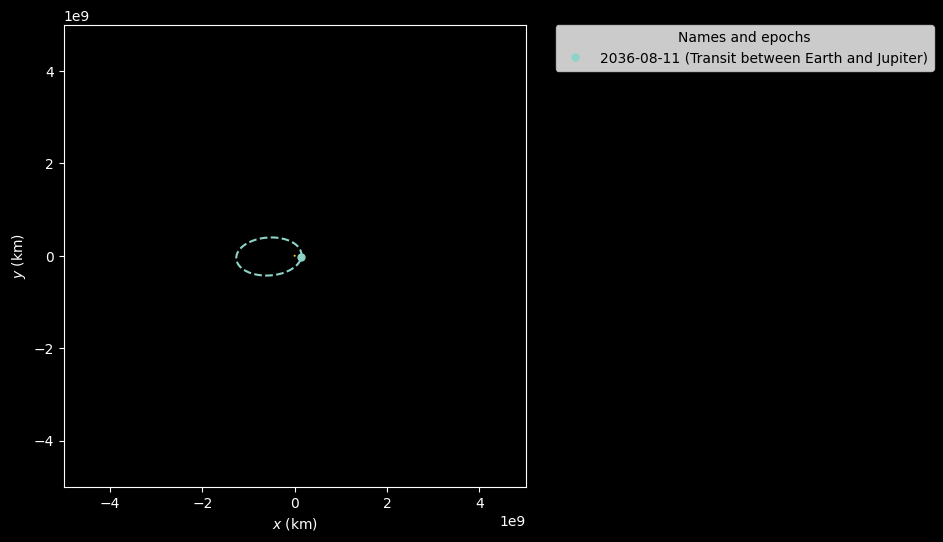

In [12]:
plotter = StaticOrbitPlotter(dark=True)
print(planet_order)
# Plot all voyager orbits
# print(voyager_orbits)

# Plot all planet orbits at encounter times
for i, po in enumerate(planet_orbits):
    plotter.plot(po, label=f"{planet_order[i].name} orbit")
    

for i, vo in enumerate(voyager_orbits):
    # print(vo)
    plotter.plot(vo, label=f"Transit between {planet_order[i].name} and {planet_order[i+1].name}")
    # print(f"Transit between {planet_order[i].name} and {planet_order[i+1].name}'}")


# Get the matplotlib Axes (poliastro versions differ: ax vs _ax)
ax = getattr(plotter, "ax", None) or plotter._ax

# Example: zoom to a +/- 5e8 km box around (0,0)
range=5e9
ax.set_xlim(-range, range)
ax.set_ylim(-range, range)
ax.set_aspect("equal", adjustable="box")

plt.show()

In [ ]:

# 1977-09-01 18:43:24.514 1979-06-22 18:43:24.514 11889.144703103324 km / s
time_1 = time.Time("1977-08-20 18:43:24.514", scale="utc").tdb
time_2 = time.Time("1979-06-09 18:43:24.514", scale="utc").tdb
time_3 = time.Time("1994-08-25 04:00:00", scale="utc").tdb

ephem_earth = Ephem.from_body(Earth, time_range(time_1, end=time_2), plane=Planes.EARTH_ECLIPTIC)
ephem_jupiter = Ephem.from_body(Jupiter, time_range(time_1, end=time_2), plane=Planes.EARTH_ECLIPTIC)


earth_orb = Orbit.from_ephem(Sun, ephem_earth, time_1)
jupiter_orb = Orbit.from_ephem(Sun, ephem_jupiter, time_2)
man_lambert = Maneuver.lambert(earth_orb, jupiter_orb)      
ej_dv= np.linalg.norm(man_lambert[0][1].value)
print(ej_dv*u.km/u.s)




10034.059925508496 km / s
